# Speech Emotion Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import librosa
import librosa.display
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

# DataSet

We will be using **RAVDESS** dataset from kaggle https://www.kaggle.com/dmitrybabko/speech-emotion-recognition-en

Here is the filename identifiers as per the official RAVDESS website:

> - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
>  Vocal channel (01 = speech, 02 = song).
> - Emotion 
    - 01 = neutral
    - **02 = calm**
    - **03 = happy**
    - **04 = sad**
    - **05 = angry**
    - **06 = fearful**
    - 07 = disgust
    - 08 = surprised
> - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
> - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
> - Repetition (01 = 1st repetition, 02 = 2nd repetition).
> - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. `02-01-06-01-02-01-12.wav` This means the meta data for the audio file is:

> - Video-only (02)
> - Speech (01)
> - Fearful (06)
> - Normal intensity (01)
> - Statement "dogs" (02)
> - 1st Repetition (01)
> - 12th Actor (12) - Female (as the actor ID number is even)

In [3]:
import os

In [4]:
labels = os.listdir("Data/")

In [5]:
# Removing the emotions which are not necessary for us to predict

# for label in labels:
#     emotion = label.split("-")[2]
    
#     if emotion == "01" or emotion == "08" or emotion == "07":
#         os.remove(f"Data/{label}")

In [6]:
labels[1]

'03-01-02-01-01-01-02.wav'

In [7]:
data, sampling_rate = librosa.load(f"Data/{labels[1]}")

Populating the interactive namespace from numpy and matplotlib


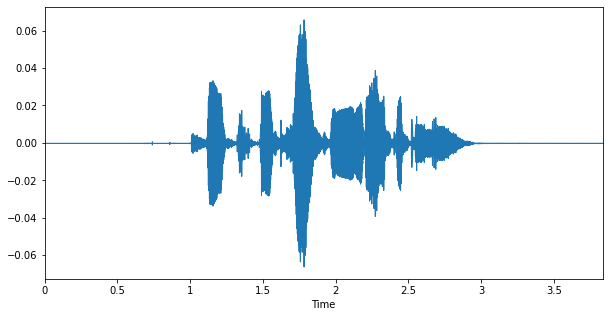

In [8]:
%pylab inline

plt.figure(figsize=(10,5))
librosa.display.waveplot(data, sr=sampling_rate);

In [9]:
# filename
labels[0]

'03-01-02-01-01-01-01.wav'

In [10]:
# Extracting the feelings
labels[0].split("-")[2]

'02'

Now we need to make an array of feeling which will act as labels which we will predict

## Emotion 
- 02 = calm
- 03 = happy
- 04 = sad
- 05 = angry
- 06 = fearful

In [11]:
emotions = [label.split("-")[2] for label in labels]

In [12]:
emotions[:5]

['02', '02', '02', '02', '02']

In [13]:
pd.DataFrame(emotions, columns=["Emotions"]).value_counts().sort_index()

Emotions
02          192
03          192
04          192
05          192
06          192
dtype: int64

## Extracting features

In [14]:
%%time
df_features = pd.DataFrame(columns=["features"])
indx = 0
for filename in labels:
    
    X, sample_rate = librosa.load(f"Data/{filename}", duration=2.5)
    # Convert sample_rate to numpy arra
    sample_rate = np.array(sample_rate)
    
    # mfccs
    feature = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    
    df_features.loc[indx] = [feature]
    indx += 1

Wall time: 1min 28s


In [15]:
df_features.head(5)

,features
0,"[-64.652176, -60.50837, -58.821392, -62.919132..."
1,"[-64.67243, -64.67243, -64.67243, -64.67243, -..."
2,"[-65.21534, -65.21534, -65.21534, -65.21534, -..."
3,"[-65.89478, -65.89478, -65.89478, -65.89478, -..."
4,"[-58.438316, -58.20555, -57.659935, -58.23138,..."


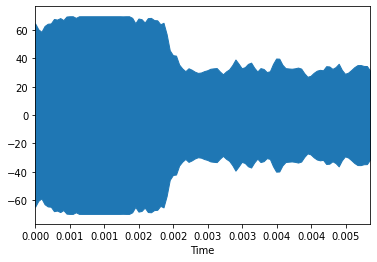

In [16]:
librosa.display.waveplot(df_features['features'][0])

In [17]:
# Create data frame of emotions
df_emotions = pd.DataFrame(emotions, columns=["emotions"])
df_emotions.head()

,emotions
0,02
1,02
2,02
3,02
4,02


In [22]:
df_feature_seperated = pd.DataFrame(df_features["features"].values.tolist())
df_feature_seperated.head()

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,-64.652176,-60.508369,-58.821392,-62.919132,-64.483536,-64.696297,-67.845940,-67.414764,-68.469673,-67.056213,...,-31.926777,-29.145128,-29.944395,-31.795519,-33.848934,-35.280262,-35.331539,-34.695477,-34.624012,-31.479322
1,-64.672432,-64.672432,-64.672432,-64.672432,-64.672432,-64.672432,-64.672432,-64.338692,-64.207451,-64.659721,...,-35.963501,-36.086235,-37.287598,-38.988159,-41.224300,-38.731339,-38.154587,-39.303234,-39.683945,-37.240246
2,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,...,-29.510120,-30.468102,-32.467644,-29.761280,-28.361540,-30.059671,-32.765923,-36.949753,-39.047466,-36.076885
3,-65.894783,-65.894783,-65.894783,-65.894783,-65.894783,-65.894783,-65.894783,-65.894783,-65.894783,-65.894783,...,-42.869411,-46.173058,-47.810646,-48.506367,-48.831707,-47.039185,-44.850281,-43.919144,-40.734531,-30.645885
4,-58.438316,-58.205551,-57.659935,-58.231380,-63.307518,-64.359924,-61.740017,-62.526619,-59.844536,-59.112312,...,-37.033531,-37.223648,-36.819881,-36.175217,-35.902103,-38.210945,-39.565117,-36.488632,-30.989864,-27.440950


In [40]:
df = df_feature_seperated
df['emotions'] = df_emotions

In [41]:
df

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,emotions
0,-64.652176,-60.508369,-58.821392,-62.919132,-64.483536,-64.696297,-67.845940,-67.414764,-68.469673,-67.056213,...,-29.145128,-29.944395,-31.795519,-33.848934,-35.280262,-35.331539,-34.695477,-34.624012,-31.479322,02
1,-64.672432,-64.672432,-64.672432,-64.672432,-64.672432,-64.672432,-64.672432,-64.338692,-64.207451,-64.659721,...,-36.086235,-37.287598,-38.988159,-41.224300,-38.731339,-38.154587,-39.303234,-39.683945,-37.240246,02
2,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,...,-30.468102,-32.467644,-29.761280,-28.361540,-30.059671,-32.765923,-36.949753,-39.047466,-36.076885,02
3,-65.894783,-65.894783,-65.894783,-65.894783,-65.894783,-65.894783,-65.894783,-65.894783,-65.894783,-65.894783,...,-46.173058,-47.810646,-48.506367,-48.831707,-47.039185,-44.850281,-43.919144,-40.734531,-30.645885,02
4,-58.438316,-58.205551,-57.659935,-58.231380,-63.307518,-64.359924,-61.740017,-62.526619,-59.844536,-59.112312,...,-37.223648,-36.819881,-36.175217,-35.902103,-38.210945,-39.565117,-36.488632,-30.989864,-27.440950,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,-34.978626,-34.472298,-34.004665,-33.757816,-34.137550,-34.410126,-34.400505,-34.668816,-35.182659,-35.192142,...,-25.568857,-26.446938,-25.342939,-23.242434,-22.911083,-18.595371,-12.529722,-10.187730,-0.681597,06
956,-52.931881,-52.931881,-52.363853,-52.418266,-52.931881,-52.931881,-52.931881,-52.931881,-52.931881,-52.931881,...,-17.687298,-15.399657,-18.837555,-22.027792,-24.056715,-24.319740,-23.004606,-19.937389,-13.328818,06
957,-50.482948,-50.482948,-50.101009,-50.482948,-49.729347,-49.878212,-50.137985,-50.482948,-50.482948,-50.482948,...,-45.780838,-46.122562,-43.202682,-40.208458,-40.140549,-40.228329,-40.260616,-27.892351,-14.105631,06
958,-56.630241,-56.630241,-56.630241,-56.630241,-56.630241,-56.630241,-56.630241,-56.630241,-56.630241,-56.630241,...,-29.667498,-31.038094,-33.447685,-32.922840,-32.364292,-31.843697,-33.033077,-32.782200,-34.437946,06


In [42]:
# Export the extracted features and emotions to csv file

# df.to_csv("Audio_Data.csv", index=False)

In [43]:
# Re-import the data
df = pd.read_csv("Audio_Data.csv")

In [44]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,emotions
0,-64.652176,-60.50837,-58.821392,-62.919132,-64.483536,-64.696300,-67.845940,-67.414764,-68.469670,-67.056210,...,-29.145128,-29.944395,-31.795519,-33.848934,-35.280262,-35.331540,-34.695477,-34.624012,-31.479322,2
1,-64.672430,-64.67243,-64.672430,-64.672430,-64.672430,-64.672430,-64.672430,-64.338690,-64.207450,-64.659720,...,-36.086235,-37.287598,-38.988160,-41.224300,-38.731340,-38.154587,-39.303234,-39.683945,-37.240246,2
2,-65.215340,-65.21534,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,...,-30.468102,-32.467644,-29.761280,-28.361540,-30.059671,-32.765923,-36.949753,-39.047466,-36.076885,2
3,-65.894780,-65.89478,-65.894780,-65.894780,-65.894780,-65.894780,-65.894780,-65.894780,-65.894780,-65.894780,...,-46.173058,-47.810646,-48.506367,-48.831707,-47.039185,-44.850280,-43.919144,-40.734530,-30.645885,2
4,-58.438316,-58.20555,-57.659935,-58.231380,-63.307518,-64.359924,-61.740017,-62.526620,-59.844536,-59.112312,...,-37.223648,-36.819880,-36.175217,-35.902103,-38.210945,-39.565117,-36.488632,-30.989864,-27.440950,2
